In [19]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd

# Load the dataset

In [5]:
data_nodes = pd.read_csv("node_oriented_dataset.csv")

# Assign Weigths

In [6]:
account_to_device = pd.DataFrame(data_nodes.groupby(["AccountName"])["DeviceInfo"].value_counts())
account_to_device.columns=["weight"]

In [7]:
account_to_device = account_to_device.reset_index()

In [8]:
merged = pd.merge(account_to_device, 
                  data_nodes, 
                  on=["AccountName", "DeviceInfo"])

# Save the relation to the disk

In [9]:
merged[["AccountName", 
        "DeviceInfo", 
        "weight", 
        "TransactionID", 
        "isFraud", 
        "TransactionDT", 
        "TransactionAmt", 
        "ProductCD"]].to_csv("weights_account_to_device.csv")

In [ ]:
def getData(node_oriented_df):

    # obtain weights based on usage frequencies
    account_to_device = pd.DataFrame(data_nodes.groupby(["AccountName"])["DeviceInfo"].value_counts())

    # assign weight attribute
    account_to_device.columns = ["weight"]
    account_to_device = account_to_device.reset_index()

    # merge weights data and the already available accounts data
    merged = pd.merge(account_to_device,
                      data_nodes,
                      on=["AccountName", "DeviceInfo"])

    # save the data frame to the disk
    merged[["AccountName",
            "DeviceInfo",
            "weight",
            "TransactionID",
            "isFraud",
            "TransactionDT",
            "TransactionAmt",
            "ProductCD"]].to_csv("weights_account_to_device.csv")

    return merged


In [20]:
def getNodesData(data):
    accounts = data["AccountName"].unique()
    devices = data["DeviceInfo"].unique()
    nodes = list(accounts)
    labels = []
    for account in accounts:
        labels.append("node")
    for device in devices:
        labels.append("device")
        nodes.append(device)

    header = ["node", "label"]
    nodes_info = pd.DataFrame([nodes, labels]).T
    nodes_info.columns = header

    return nodes_info

In [21]:
def getEdgesData(data):
    edges_data = data[["AccountName", "weight", "TransactionID", "isFraud", "TransactionDT", "TransactionAmt", "ProductCD", "DeviceInfo"]]
    edges_data = edges_data.assign(Type="TRANSACTION")
    return edges_data

In [ ]:
def saveEdgesData(data):

    # create exports directory to copy-paste its contents to Neo4j database folder
    if not os.path.isdir("export"):
        os.mkdir("export")

    # get the data related to edges
    edges_data = getEdgesData(data)

    # save edges data to a CSV file with no header nor index
    edges_data.to_csv("export/edges_data.csv", header=False, index=False)

    # save a CSV header file
    with open("export/edges_header.csv", 'w') as fh:
        fh.write(":START_ID,weight:int,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,:END_ID,:TYPE")

    # upon successful exit, return 0
    return 0

In [ ]:
def saveNodesData(data):

    # create exports directory to copy-paste its contents to Neo4j database folder
    if not os.path.isdir("export"):
        os.mkdir("export")

    # get the data related to nodes
    nodes_data = getNodesData(data)

    # save edges data to a CSV file with no header nor index
    nodes_data.to_csv("export/nodes_data.csv", header=False, index=False)

    # save a CSV header file
    with open("export/nodes_header.csv", 'w') as fh:
        fh.write("id:ID,label:LABEL")

    # upon successful exit, return 0
    return 0

In [22]:
nodes_data = getNodesData(merged)

In [23]:
edges_data = getEdgesData(merged)

In [24]:
if not os.path.isdir("export"):
    os.mkdir("export")
nodes_data.to_csv("export/nodes_data.csv", header=False, index=False)
with open("export/nodes_header.csv", 'w') as fh:
    fh.write("id:ID,label:LABEL")

In [25]:
edges_data.to_csv("export/edges_data.csv", header=False, index=False)
with open("export/edges_header.csv", 'w') as fh:
    fh.write(":START_ID,weight:int,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,:END_ID,:TYPE")

# Creating the graph

In [ ]:
import os
import pandas as pd


def buildManager(path_edges, path_features, path_classes, time_step=None):

    data_edges = pd.read_csv(path_edges)
    data_features = pd.read_csv(path_features, header=None)
    data_classes = pd.read_csv(path_classes)

    if time_step is None:
        nodes = extractAllTimestepsNodes(data_features=data_features)
        createNodesHeaderFile(nodes_header="id:ID,class:int,label:LABEL", output_directory="../export_all_timesteps")
        createNodesDataFile(data_classes=data_classes, nodes_timestamp_x=nodes,
                            output_directory="../export_all_timesteps")
        edgelist = data_edges
        createEdgesHeaderFile(edges_header=":START_ID,cost:int,:END_ID,:TYPE", output_directory="../export_all_timesteps")
        createEdgesDataFile(edgelist, output_directory="../export_all_timesteps")

    else:
        nodes_timestep = extractTimestepNodes(data_features=data_features, timestep=time_step)

        createNodesHeaderFile(nodes_header="id:ID,class:int,label:LABEL",
                              output_directory=f"../export_timestep_{time_step}")

        createNodesDataFile(data_classes=data_classes,
                            nodes_timestamp_x=nodes_timestep,
                            output_directory=f"../export_timestep_{time_step}")

        edgelist_timestep = getTimestepEdgelist(nodes_timestep_x=nodes_timestep, data_edges=data_edges)
        createEdgesHeaderFile(edges_header=":START_ID,cost:int,:END_ID,:TYPE",
                              output_directory=f"../export_timestep_{time_step}")

        createEdgesDataFile(edgelist_timestep,
                            output_directory=f"../export_timestep_{time_step}")

    return 0


def extractAllTimestepsNodes(data_features):
    nodes_timestep_x = data_features["AccountName"]
    nodes_timestep_x = pd.DataFrame(nodes_timestep_x)
    nodes_timestep_x.columns = ["AccountName"]
    return nodes_timestep_x


def extractTimestepNodes(data_features, timestep=1):
    nodes_timestep_x = data_features["TransactionDT" == timestep]["AccountName"]
    nodes_timestep_x = pd.DataFrame(nodes_timestep_x)
    nodes_timestep_x.columns = ["AccountName"]
    return nodes_timestep_x


def getTimestepEdgelist(nodes_timestep_x, data_edges):
    # make sure that the transactions exist in a time step
    # select only those records which transaction IDs exist in timestep1 list
    nodes_timestep_x = nodes_timestep_x["AccountName"].unique()
    accounts_timestep_x = []
    devices_timestep_x = []
    index = 0
    for i in range(len(data_edges)):
        index += 1
        print(f"Progress: {index} / {len(data_edges)}", end='\r')

        if (data_edges.txId1.iloc[i] in nodes_timestep_x) & (data_edges.txId2.iloc[i] in nodes_timestep_x):
            txId1_timestep_x.append(data_edges.txId1.iloc[i])
            txId2_timestep_x.append(data_edges.txId2.iloc[i])

    data_edges_timestep_x = pd.DataFrame([txId1_timestep_x, txId2_timestep_x]).T
    data_edges_timestep_x.columns = ["txId1", "txId2"]

    return data_edges_timestep_x


def createNodesHeaderFile(nodes_header, output_directory="export"):
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)

    with open(f"{output_directory}/nodes_header.csv", 'w') as fh:
        fh.write(nodes_header)

    return 0


def createNodesDataFile(data_classes, nodes_timestamp_x, output_directory="export"):

    data_classes_timestep_x = pd.merge(data_classes, nodes_timestamp_x, on="txId")
    data_classes_timestep_x["class"] = data_classes_timestep_x["class"].replace({"unknown" : 3}).astype("uint8")
    data_classes_timestep_x = data_classes_timestep_x.assign(label="node")
    data_classes_timestep_x.to_csv(f"{output_directory}/nodes_data.csv", header=False, index=False)

    return 0


def createEdgesHeaderFile(edges_header, output_directory="export"):
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)

    with open(f"{output_directory}/edges_header.csv", 'w') as fh:
        fh.write(edges_header)

    return 0


def createEdgesDataFile(edgelist_timestep_x, output_directory="export"):
    # for obtaining relationship properties, the edge properties must be added using the data from the edgelist
    # the properties must be between START ID and END ID
    edges_timestep_x = edgelist_timestep_x[["txId1"]]
    edges_timestep_x = edges_timestep_x.assign(cost=1)
    edges_timestep_x = edges_timestep_x.assign(txId2=edgelist_timestep_x["txId2"])
    edges_timestep_x = edges_timestep_x.assign(Type="TRANSACTION")
    edges_timestep_x.to_csv(f"{output_directory}/edges_data.csv", header=False, index=False)

    return 0


In [ ]:
nodes_header = ""

In [14]:
accounts_devices_weight = merged.drop_duplicates(subset=["AccountName", "DeviceInfo"])[["AccountName", "DeviceInfo", "weight"]]

In [15]:
accounts_devices_weight

,AccountName,DeviceInfo,weight
0,10003555128226v5,S60 Build/MMB29M,3
3,10004529150162v6,Windows,3
6,10004529150162v6,iOS Device,3
9,10004529150162v6,Trident/7.0,2
11,10004529150162v6,MacOS,1
...,...,...,...
117367,9995479150166v5,Trident/7.0,1
117368,9995479150166v5,Windows,1
117369,9999174150226v5,rv:11.0,15
117384,9999174150226v5,Trident/7.0,1


In [68]:
graphtype = nx.Graph()
graph = nx.from_pandas_edgelist(merged, source="AccountName", target="DeviceInfo",
                                             edge_attr=True, create_using=graphtype)

In [70]:
# plt.figure(figsize=(15,10))
# nx.draw(graph)

In [71]:
# from pyvis.network import Network

# nt = Network("2000px", "2000px", bgcolor="#222222", font_color="white")
# nt.from_nx(graph)
# nt.show("test.html")

In [72]:
# edge_colors = ['r' if attrs["isFraud"] else 'b' for attrs in graph.edges.values()]
# edge_widths = [1 if attrs["weight"] else 5 for attrs in graph.edges.values()]

In [73]:
# plt.figure(figsize=(20,20))
# plt.title(f"Subgraph: component number 1\nComponent size: {graph.size()}", fontsize=20)
# nx.draw(graph, with_labels=True, edge_color=edge_colors, width=edge_widths)

In [ ]:
# AccountName:ID, P_emaildomain
# DeviceInfo:ID

# :START_ID,:END_ID, weight:long, TransactionID:long, DeviceType, isFraud:long, TransactionDT:long, TransactionAmt:double, :TYPE, card1:double, card2:double, card3:double, card4:double, card5:double, card6:double, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain:TYPE

In [62]:
# pd.Series(np.array(merged["AccountName"].unique())).to_csv("neo4j_csv_files/source_nodes.csv", index=False, header=False)
# pd.Series(np.array(merged["DeviceInfo"].unique())).to_csv("neo4j_csv_files/destination_nodes.csv", index=False, header=False)
# merged.to_csv("neo4j_csv_files/edge_properties.csv", index=False, header=False)

In [74]:
components = sorted(nx.connected_components(graph), key=len, reverse=True)
sub_graph = graph.subgraph(components[0])
degree_distribution = nx.degree(graph)
nodes = []
degree_scores = []
for d in list(degree_distribution):
    nodes.append(d[0])
    degree_scores.append(d[1])

degree_dist = pd.DataFrame(nodes, degree_scores).reset_index()
degree_dist.columns = ["degree", "node"]

In [76]:
# nx.draw(sub_graph)

In [77]:
len(components)

50

In [78]:
sub_graph.size()

25927

In [84]:
degree_dist

,degree,node
0,1,10003555128226v5
1,2,S60 Build/MMB29M
2,6,10004529150162v6
3,4793,Windows
4,3051,iOS Device
...,...,...
9521,5,9992455150126m5
9522,1,9993399150185a6
9523,1,9994442150226v6
9524,2,9995479150166v5


# How many devices do the customers use

In [92]:
# list of devices for each user
devices_list = pd.DataFrame(merged.groupby("AccountName")["DeviceInfo"].apply(list))
# counts for devices used by the customers
number_of_devices = devices_list["DeviceInfo"].apply(len)

In [96]:
print(f"Mean number of devices: {number_of_devices.mean()}")
print(f"Median number of devices: {number_of_devices.median()}")
print(f"Max number of devices: {number_of_devices.max()}")

Mean number of devices: 15.14658064516129
Median number of devices: 2.0
Max number of devices: 6761


In [105]:
numbers_df = pd.DataFrame(number_of_devices).reset_index()
numbers_df.columns = ["AccountName", "Counts"]

<AxesSubplot:xlabel='Counts', ylabel='Count'>

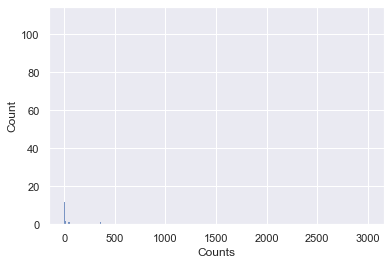

In [109]:
import seaborn as sns
sns.set()
sns.histplot(numbers_df["Counts"].value_counts())

# Most common device info

In [119]:
merged["DeviceInfo"].mode()

0    Windows
dtype: object

In [120]:
sum(merged["DeviceInfo"] == "Windows")

47256

In [123]:
merged["DeviceInfo"].value_counts()[:20]

Windows                        47256
iOS Device                     19584
MacOS                          12459
Trident/7.0                     7361
rv:11.0                         1883
rv:57.0                          948
SM-J700M Build/MMB29K            546
SM-G610M Build/MMB29K            459
SM-G531H Build/LMY48B            409
rv:59.0                          356
SM-G935F Build/NRD90M            333
SM-G955U Build/NRD90M            323
SM-G532M Build/MMB29T            316
ALE-L23 Build/HuaweiALE-L23      311
SM-G950U Build/NRD90M            282
SM-G930V Build/NRD90M            273
rv:58.0                          267
rv:52.0                          256
SAMSUNG                          231
SM-G950F Build/NRD90M            225
Name: DeviceInfo, dtype: int64

In [110]:
graph

In [126]:
sub_graph = graph.subgraph(components[1])

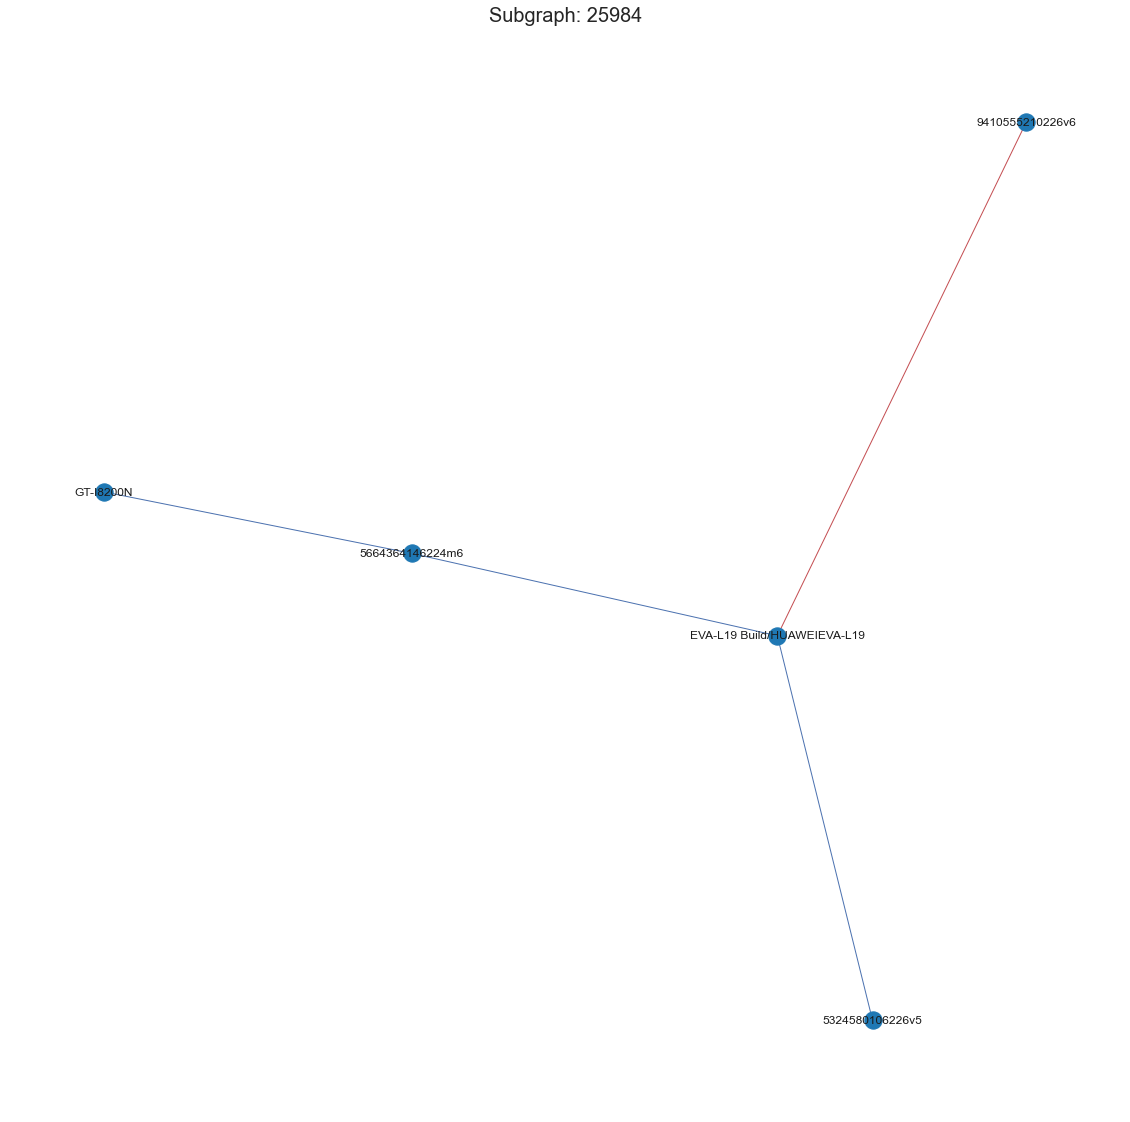

In [127]:
edge_colors = ['r' if attrs["isFraud"] else 'b' for attrs in graph.edges.values()]
edge_widths = [1 if attrs["weight"] else 5 for attrs in graph.edges.values()]
plt.figure(figsize=(20,20))
plt.title(f"Subgraph: {graph.size()}", fontsize=20)
nx.draw(sub_graph, with_labels=True, edge_color=edge_colors, width=edge_widths)

In [128]:
graph.size()

25984

In [129]:
nx.transitivity(graph.subgraph(components[0]))

0

In [144]:
degree_whole_graph = pd.DataFrame(list(nx.degree(graph)))
degree_whole_graph.columns = ["node", "degree"]
degree_whole_graph.degree.value_counts()[:20]

1     4540
2     1746
3     1054
4      586
5      384
6      234
7      139
8      102
9      100
10      68
12      53
11      46
13      45
16      32
15      30
14      25
20      24
21      23
19      17
26      17
Name: degree, dtype: int64

In [134]:
degree_df = pd.DataFrame(list(nx.degree(graph.subgraph(components[0]))))

In [136]:
degree_df.columns = ["node", "degree"]

In [139]:
degree_df.degree.value_counts()[:20]

1     4441
2     1740
3     1053
4      586
5      384
6      234
7      139
8      102
9      100
10      68
12      53
11      46
13      45
16      32
15      30
14      25
20      24
21      23
19      17
26      17
Name: degree, dtype: int64

In [140]:
nx.transitivity(graph)

0

In [143]:
max_values = np.array([max(j.values()) for (i, j) in nx.shortest_path_length(graph)])
diameter = np.max(max_values)
diameter

9

In [147]:
nx.is_connected(graph)

False